In [1]:
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table, load_table
from scipy.stats import ttest_ind, pearsonr
from skbio.diversity.alpha import shannon
from qiime2.plugins.feature_table.methods import rarefy
import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import gOTU table
bt = load_table('../data/FINRISK/microbiome-table.biom')
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
btdf = pd.DataFrame(bt.matrix_data.toarray(), bt.ids('observation'), bt.ids())
# import glycogene table
table_glycodf = pd.read_csv('../data/FINRISK/glycosidase-counts.tsv',
                            index_col=0)
# import metadata
meta = pd.read_csv('../data/FINRISK/metadata.tsv', index_col=0)
# import pathwat model predictions
glco_loadings = pd.read_csv('../data/pathway-model/HS-completeness-capacity.csv',
                            index_col=0)
# import taxonomy for gOTUS
tax_map = pd.read_csv('../data/wol-organism-tax.tsv', sep='\t', index_col=0, header=None)
tax_map['sp'] = [' '.join(x.split(' ')[:2]) for x in tax_map[1]]
tax_map = tax_map.reindex(sorted(set(tax_map.index) & set(btdf.index)))
pathway_microbe_map = {target_:set(df[df.pathway_completeness_abundance == 1].taxa.dropna())
                       for target_, df in glco_loadings.groupby('Target')}


/Users/cmartino/miniconda3/envs/qiime2-2021.11/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def lratio(df, n, d):
    
    """
    Function for log-ratio
    """
    
    lr_ = np.log(df.loc[n, :].sum(0)) - np.log(df.loc[d, :].sum(0))
    lr_[~np.isfinite(lr_)] = np.nan
    return  lr_.values

# take glyco log-ratios based on bio. quesiton
meta['endolytic-degredation'] = lratio(table_glycodf + 1,
                                       ['heparan-sulfate-lyase'],
                                       ['housekeeping'])
# take microbe ratio
for type_, spp_ in pathway_microbe_map.items():
    other_ = set(tax_map['sp']) - spp_
    n_ = tax_map[tax_map['sp'].isin(spp_)].index
    d_ = tax_map[tax_map['sp'].isin(other_)].index
    meta[type_] = lratio(btdf, n_, d_)


In [4]:
# rareify for alpha-diversity
table_rare = rarefy(table, 5000).rarefied_table
bt_rare = table_rare.view(Table)
btdf_rare = pd.DataFrame(bt_rare.matrix_data.toarray(),
                         bt_rare.ids('observation'),
                         bt_rare.ids())
# get alpha diversity and add to metadata
div_ = pd.DataFrame([shannon(btdf_rare.iloc[:,i].values)
                     for i in range(btdf_rare.shape[1])],
                    btdf_rare.columns, ['shannon_alpha_rare']).reindex(meta.index)
meta = pd.concat([div_, meta], axis=1)


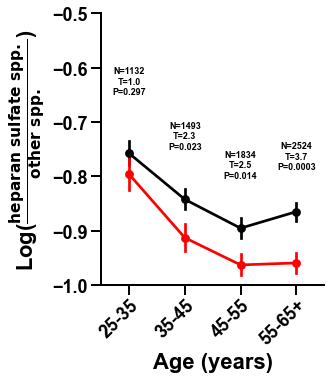

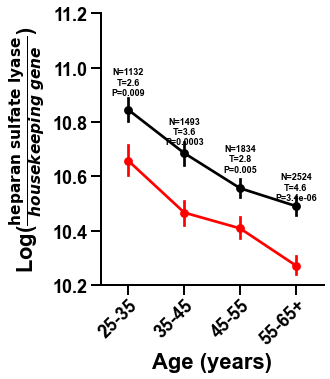

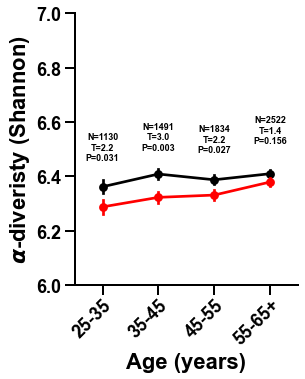

In [5]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Female':'black',
        'Male':'red'}
lebels={'Heparan Sulfate':'Log($\\frac{\mathrm{heparan\,\,sulfate\,\,spp.}}{\mathrm{other\,\,spp.}}$)',
        'endolytic-degredation':'Log($\\frac{\\mathrm{heparan\,\,sulfate\,\,lyase}}{housekeeping\,\,gene}$)',
        'shannon_alpha_rare':'$\\alpha$-diveristy (Shannon)'}
ylims={'Heparan Sulfate':(-1,-.5),
       'endolytic-degredation':(10.2,11.2),
       'shannon_alpha_rare':(6,7)}
label_ = ['25-35',
          '35-45',
          '45-55',
          '55-65+']


for y_, fig_ in zip(['Heparan Sulfate','endolytic-degredation','shannon_alpha_rare'],
                      ['Fig2A','Fig2B','FigS1A']):
    
    fig, ax = plt.subplots(1, 1, figsize=(4,5), sharex=True)
    
    meta_plt = meta[[y_,'age_groups','sex']].dropna().rename({y_:'log_ratio'},axis=1)
    meta_plt = meta_plt.dropna(subset=['log_ratio'])

    title_ = y_
    label_x = lebels[y_]
    min_, max_ = ylims[y_]
    y_ = 'log_ratio'

    sns.pointplot(y=y_,
                  x='age_groups',
                  hue='sex',
                  order=label_,
                  palette=pal_,
                  data=meta_plt,
                  ci=68,
                  ax=ax)

    ax.set_ylabel(label_x,
                  fontsize=22,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('Age (years)',
                  fontsize=22,
                  family = 'arial',
                  weight='bold',
                  color='black')

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    ax.set_ylim(min_, max_)

    # add a legend
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:], labels[:],
                        prop={'size':12}, loc=2, 
                        bbox_to_anchor=(.35, .95),
                        fancybox=True, framealpha=0.8,ncol=2
                        , markerscale=1.5, facecolor="white")
    ax.legend_.remove()


    max_ = []
    for x_, k_ in enumerate(label_):
        df_ = meta_plt[meta_plt.age_groups == k_]
        t_, p_ = ttest_ind(df_[df_.sex == 'Female'][y_].dropna().values,
                           df_[df_.sex == 'Male'][y_].dropna().values)
        y, h, col = df_[y_].mean() - .03, .1, 'k'
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "N=%s\nT=%.1f\nP=%s" % (str(df_.shape[0]),t_,p_)
        elif p_ > .001:
            p_ = "N=%s\nT=%.1f\nP=%.3f" % (str(df_.shape[0]),t_,p_)
        elif p_ > .00001:
            p_ = "N=%s\nT=%.1f\nP=%.4f" % (str(df_.shape[0]),t_,p_)
        max_.append(y+h)
        ax.text(x_, y+h+.05, p_, weight='bold',
                ha='center', va='bottom',
                family = 'arial', 
                color=col, fontsize=9)

    
    # set the backrounf to be transparent
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)
    plt.savefig('../results/figures/%s.pdf' % (fig_),
                dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()


In [6]:

# ensure no missing values from log-ratio
meta_corr = meta.dropna(subset=['shannon_alpha_rare','Heparan Sulfate'])
# get correlation
corr_res = {}
for k_, df_ in meta_corr.groupby('sex'):
    corr_res[('FINRISK 2002', k_)] = pearsonr(df_['shannon_alpha_rare'].values,
                            df_['Heparan Sulfate'].values)
resdf = pd.DataFrame(corr_res, ['R', 'p-value'])
resdf.to_csv('../results/tables/table-s2.csv')
resdf

    

FINRISK 2002               
                Female           Male
R        -4.748115e-01  -3.657754e-01
p-value  1.208507e-222  8.652106e-103

In [7]:
y_='Heparan Sulfate'
inc_ = ['DIAB_T1','EX_SMOKE','BMI','ASTHMA',
        'CR_ANYCANC','CVD','FIBROS_CHIRROS',
        'AUTOIMMUN']
meta_stat =  meta.dropna(subset=[y_,'age_groups']).rename({y_:'log_ratio'},axis=1).copy()
map_ = {j:i for i, j in enumerate(label_)}
meta_stat['age'] = [map_[v_] for v_ in meta_stat['age_groups']]
mod = smf.ols(formula='log_ratio ~ age + sex + ' + ' + age*'.join(inc_),
              data=meta_stat)
res = mod.fit()
resdf = res.summary2().tables[1].loc[['age','sex[T.Male]'] + inc_]
resdf = resdf.rename({'age':'age', 'sex[T.Male]':'sex', 'DIAB_T1':'diabetes',
                      'EX_SMOKE':'ex-smoker', 'BMI':'BMI', 'ASTHMA':'asthma',
                      'CR_ANYCANC':'cancer', 'CVD':'cardiovascular disease',
                      'FIBROS_CHIRROS':'liver fibrosis or cirrhosis',
                      'AUTOIMMUN':'autoimmune disease'},axis=0)
resdf.to_csv('../results/tables/table-s1.csv')
resdf


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
age,-0.067069,0.039696,-1.689545,9.116064e-02,-0.144886,0.010748
sex,-0.079358,0.015443,-5.138873,2.840390e-07,-0.109631,-0.049086
diabetes,0.085952,0.082389,1.043246,2.968713e-01,-0.075556,0.247460
ex-smoker,-0.046402,0.039051,-1.188252,2.347753e-01,-0.122954,0.030150
BMI,0.002866,0.003193,0.897455,3.695076e-01,-0.003394,0.009125
asthma,0.090289,0.042941,2.102635,3.553411e-02,0.006112,0.174466
cancer,-0.056554,0.069335,-0.815667,4.147192e-01,-0.192473,0.079364
cardiovascular disease,0.023468,0.086007,0.272862,7.849675e-01,-0.145133,0.192069
liver fibrosis or cirrhosis,-1.014322,0.512951,-1.977424,4.803382e-02,-2.019866,-0.008778
autoimmune disease,0.107838,0.083195,1.296200,1.949501e-01,-0.055251,0.270926
